## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()


def gen_data(mean = 0, var = 1, SIZE = 20000):
    
    
    
    
    a = np.random.normal(mean,var, SIZE)
    b = np.random.normal(mean, var, SIZE)
    c = a * b + np.random.normal(mean, var, SIZE)
    d = -c - np.random.normal(mean, var, SIZE)
    

    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d})

def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()



from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models =20
model_layers = [2048, 2048, 512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/f' + str(i))

print(models, model_names)

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'gfci', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 2
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a
full_conx = get_pairs(['a', 'b', 'c', 'd'])
forced_conx = set({('a','c'), ('b','c'),('c','d') })
restricted_conx = full_conx.difference(forced_conx)   

prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )



inputs = ['a','b','d']
target = ['c']


df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[[2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512]] ['temp/f0', 'temp/f1', 'temp/f2', 'temp/f3', 'temp/f4', 'temp/f5', 'temp/f6', 'temp/f7', 'temp/f8', 'temp/f9', 'temp/f10', 'temp/f11', 'temp/f12', 'temp/f13', 'temp/f14', 'temp/f15', 'temp/f16', 'temp/f17', 'temp/f18', 'temp/f19']


In [2]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/f0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 4s 179us/step - loss: 0.6170 - mean_squared_error: 0.6170 - val_loss: 0.5281 - val_mean_squared_error: 0.5281

Epoch 00001: val_loss improved from inf to 0.52813, saving model to temp/f0
Epoch 2/20
20000/20000 [==============================] - 3s 134us/step - loss: 0.5293 - mean_squared_error: 0.5293 - val_loss: 0.5284 - val_mean_squared_error: 0.5284

Epoch 00002: val_loss did not improve from 0.52813
Epoch 3/20
20000/20000 [==============================] - 3s 130us/step - loss: 0.5228 - mean_squared_error: 0.5228 - val_loss: 0.5247 - val_mean_squared_error: 0.5247

Epoch 00003: val_loss improved from 0.52813 to 0.52470, saving model to temp/f0
Epoch 4/20
20000/20000 [==============================] - 3s 128us/step - loss: 0.5212 - mean_squared_error: 0.5212 - val_loss: 0.5196 - val_mean_squared_error: 0.5196

Epoch 00004: val_loss improved from 0.52470 to 0.51961, sav

20000/20000 [==============================] - 3s 128us/step - loss: 0.5104 - mean_squared_error: 0.5104 - val_loss: 0.5106 - val_mean_squared_error: 0.5106

Epoch 00009: val_loss improved from 0.51147 to 0.51060, saving model to temp/f2
Epoch 10/20
20000/20000 [==============================] - 3s 134us/step - loss: 0.5105 - mean_squared_error: 0.5105 - val_loss: 0.5087 - val_mean_squared_error: 0.5087

Epoch 00010: val_loss improved from 0.51060 to 0.50874, saving model to temp/f2
Epoch 11/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.5106 - mean_squared_error: 0.5106 - val_loss: 0.5072 - val_mean_squared_error: 0.5072

Epoch 00011: val_loss improved from 0.50874 to 0.50721, saving model to temp/f2
Epoch 12/20
20000/20000 [==============================] - 3s 128us/step - loss: 0.5097 - mean_squared_error: 0.5097 - val_loss: 0.5041 - val_mean_squared_error: 0.5041

Epoch 00012: val_loss improved from 0.50721 to 0.50406, saving model to temp/f2
Epoch 13/20


20000/20000 [==============================] - 3s 156us/step - loss: 0.5294 - mean_squared_error: 0.5294 - val_loss: 0.5302 - val_mean_squared_error: 0.5302

Epoch 00002: val_loss did not improve from 0.52927
Epoch 3/20
20000/20000 [==============================] - 3s 157us/step - loss: 0.5254 - mean_squared_error: 0.5254 - val_loss: 0.5272 - val_mean_squared_error: 0.5272

Epoch 00003: val_loss improved from 0.52927 to 0.52723, saving model to temp/f5
Epoch 4/20
20000/20000 [==============================] - 3s 154us/step - loss: 0.5238 - mean_squared_error: 0.5238 - val_loss: 0.5198 - val_mean_squared_error: 0.5198

Epoch 00004: val_loss improved from 0.52723 to 0.51981, saving model to temp/f5
Epoch 5/20
20000/20000 [==============================] - 3s 154us/step - loss: 0.5196 - mean_squared_error: 0.5196 - val_loss: 0.5229 - val_mean_squared_error: 0.5229

Epoch 00005: val_loss did not improve from 0.51981
Epoch 6/20
20000/20000 [==============================] - 3s 154us/step -

20000/20000 [==============================] - 3s 170us/step - loss: 0.6147 - mean_squared_error: 0.6147 - val_loss: 0.5334 - val_mean_squared_error: 0.5334

Epoch 00001: val_loss improved from inf to 0.53344, saving model to temp/f8
Epoch 2/20
20000/20000 [==============================] - 3s 159us/step - loss: 0.5267 - mean_squared_error: 0.5267 - val_loss: 0.5239 - val_mean_squared_error: 0.5239

Epoch 00002: val_loss improved from 0.53344 to 0.52390, saving model to temp/f8
Epoch 3/20
20000/20000 [==============================] - 3s 160us/step - loss: 0.5237 - mean_squared_error: 0.5237 - val_loss: 0.5205 - val_mean_squared_error: 0.5205

Epoch 00003: val_loss improved from 0.52390 to 0.52049, saving model to temp/f8
Epoch 4/20
20000/20000 [==============================] - 3s 161us/step - loss: 0.5212 - mean_squared_error: 0.5212 - val_loss: 0.5183 - val_mean_squared_error: 0.5183

Epoch 00004: val_loss improved from 0.52049 to 0.51828, saving model to temp/f8
Epoch 5/20
20000/20

20000/20000 [==============================] - 3s 159us/step - loss: 0.5283 - mean_squared_error: 0.5283 - val_loss: 0.5239 - val_mean_squared_error: 0.5239

Epoch 00002: val_loss improved from 0.53014 to 0.52392, saving model to temp/f11
Epoch 3/20
20000/20000 [==============================] - 3s 159us/step - loss: 0.5233 - mean_squared_error: 0.5233 - val_loss: 0.5244 - val_mean_squared_error: 0.5244

Epoch 00003: val_loss did not improve from 0.52392
Epoch 4/20
20000/20000 [==============================] - 3s 159us/step - loss: 0.5217 - mean_squared_error: 0.5217 - val_loss: 0.5179 - val_mean_squared_error: 0.5179

Epoch 00004: val_loss improved from 0.52392 to 0.51791, saving model to temp/f11
Epoch 5/20
20000/20000 [==============================] - 3s 160us/step - loss: 0.5170 - mean_squared_error: 0.5170 - val_loss: 0.5170 - val_mean_squared_error: 0.5170

Epoch 00005: val_loss improved from 0.51791 to 0.51697, saving model to temp/f11
Epoch 6/20
20000/20000 [=================

20000/20000 [==============================] - 3s 159us/step - loss: 0.5229 - mean_squared_error: 0.5229 - val_loss: 0.5224 - val_mean_squared_error: 0.5224

Epoch 00004: val_loss improved from 0.52343 to 0.52241, saving model to temp/f13
Epoch 5/20
20000/20000 [==============================] - 3s 157us/step - loss: 0.5180 - mean_squared_error: 0.5180 - val_loss: 0.5164 - val_mean_squared_error: 0.5164

Epoch 00005: val_loss improved from 0.52241 to 0.51638, saving model to temp/f13
Epoch 6/20
20000/20000 [==============================] - 3s 159us/step - loss: 0.5168 - mean_squared_error: 0.5168 - val_loss: 0.5188 - val_mean_squared_error: 0.5188

Epoch 00006: val_loss did not improve from 0.51638
Epoch 7/20
20000/20000 [==============================] - 3s 158us/step - loss: 0.5162 - mean_squared_error: 0.5162 - val_loss: 0.5220 - val_mean_squared_error: 0.5220

Epoch 00007: val_loss did not improve from 0.51638
Epoch 00007: early stopping
temp/f14
Train on 20000 samples, validate o


Epoch 00011: val_loss improved from 0.50940 to 0.50679, saving model to temp/f15
Epoch 12/20
20000/20000 [==============================] - 3s 155us/step - loss: 0.5092 - mean_squared_error: 0.5092 - val_loss: 0.5091 - val_mean_squared_error: 0.5091

Epoch 00012: val_loss did not improve from 0.50679
Epoch 13/20
20000/20000 [==============================] - 3s 158us/step - loss: 0.5075 - mean_squared_error: 0.5075 - val_loss: 0.5071 - val_mean_squared_error: 0.5071

Epoch 00013: val_loss did not improve from 0.50679
Epoch 00013: early stopping
temp/f16
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 168us/step - loss: 0.6145 - mean_squared_error: 0.6145 - val_loss: 0.5308 - val_mean_squared_error: 0.5308

Epoch 00001: val_loss improved from inf to 0.53076, saving model to temp/f16
Epoch 2/20
20000/20000 [==============================] - 3s 153us/step - loss: 0.5296 - mean_squared_error: 0.5296 - val_loss: 0.5255 - val_me

20000/20000 [==============================] - 3s 152us/step - loss: 0.5247 - mean_squared_error: 0.5247 - val_loss: 0.5209 - val_mean_squared_error: 0.5209

Epoch 00003: val_loss improved from 0.52564 to 0.52087, saving model to temp/f18
Epoch 4/20
20000/20000 [==============================] - 3s 157us/step - loss: 0.5214 - mean_squared_error: 0.5214 - val_loss: 0.5187 - val_mean_squared_error: 0.5187

Epoch 00004: val_loss improved from 0.52087 to 0.51873, saving model to temp/f18
Epoch 5/20
20000/20000 [==============================] - 3s 153us/step - loss: 0.5184 - mean_squared_error: 0.5184 - val_loss: 0.5146 - val_mean_squared_error: 0.5146

Epoch 00005: val_loss improved from 0.51873 to 0.51464, saving model to temp/f18
Epoch 6/20
20000/20000 [==============================] - 3s 157us/step - loss: 0.5176 - mean_squared_error: 0.5176 - val_loss: 0.5123 - val_mean_squared_error: 0.5123

Epoch 00006: val_loss improved from 0.51464 to 0.51226, saving model to temp/f18
Epoch 7/20


In [3]:
nb_test = 2000
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1, 2]
variances = [1,2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = inputs)
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = target)
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


'\n            setA = get_MB(get_CG(perturbed_df, tetrad), \'g\', pc)\n            if setA != {\'f\'}:\n                print("Error in SETA markov blanket")\n                #setA = {\'f\'}\n            setC = get_MB(get_CG(test_df2, tetrad), \'g\', pc)\n\n            if setA != setC:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(1)\n            else:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(0)\n\n'

Times =  0
['a --> c', 'b --> c', 'c --> d']
-3173.088345451235
['a --> c', 'b --> c', 'c --> d']
-3182.7622265264636
['a --> c', 'b --> c', 'c --> d']
-3264.8191558371614
['a --> c', 'b --> c', 'c --> d']
-3225.6828902105913
['a --> c', 'b --> c', 'c --> d']
-3076.346813071783
['a --> c', 'b --> c', 'c --> d']
-3183.806955741884
['a --> c', 'b --> c', 'c --> d']
-3270.308463284337
['a --> c', 'b --> c', 'c --> d']
-3160.3063572396995
['a --> c', 'b --> c', 'c --> d']
-3197.223536479797
['a --> c', 'b --> c', 'c --> d']
-3231.4095946302077
['a --> c', 'b --> c', 'c --> d']
-3219.093020765762
['a --> c', 'b --> c', 'c --> d']
-3321.3805265396736
['a --> c', 'b --> c', 'c --> d']
-3192.056874053581
['a --> c', 'b --> c', 'c --> d']
-3207.6721258592893
['a --> c', 'b --> c', 'c --> d']
-3225.081322336065
['a --> c', 'b --> c', 'c --> d']
-3158.154971341197
['a --> c', 'b --> c', 'c --> d']
-3190.000951566699
['a --> c', 'b --> c', 'c --> d']
-3299.0330764105597
['a --> c', 'b --> c', 'c -

['a --> c', 'b --> c', 'c --> d']
-3632.465815941825
['a --> c', 'b --> c', 'c --> d']
-3609.8426603412745
['a --> c', 'b --> c', 'c --> d']
-3683.635404131259
['a --> c', 'b --> c', 'c --> d']
-3580.6150687636073
['a --> c', 'b --> c', 'c --> d']
-3624.7308103332903
['a --> c', 'b --> c', 'c --> d']
-3710.0566278227307
['a --> c', 'b --> c', 'c --> d']
-3729.8756082249133
['a --> c', 'b --> c', 'c --> d']
-3573.58523217396
Times =  8
['a --> c', 'b --> c', 'c --> d']
-2641.4162362703355
['a --> c', 'b --> c', 'c --> d']
-2635.8918940109584
['a --> c', 'b --> c', 'c --> d']
-2735.349663607839
['a --> c', 'b --> c', 'c --> d']
-2633.365819317391
['a --> c', 'b --> c', 'c --> d']
-2545.686503829628
['a --> c', 'b --> c', 'c --> d']
-2649.5548119094683
['a --> c', 'b --> c', 'c --> d']
-2748.436591521624
['a --> c', 'b --> c', 'c --> d']
-2614.6258485031167
['a --> c', 'b --> c', 'c --> d']
-2649.179034428474
['a --> c', 'b --> c', 'c --> d']
-2692.7930820271836
['a --> c', 'b --> c', 'c 

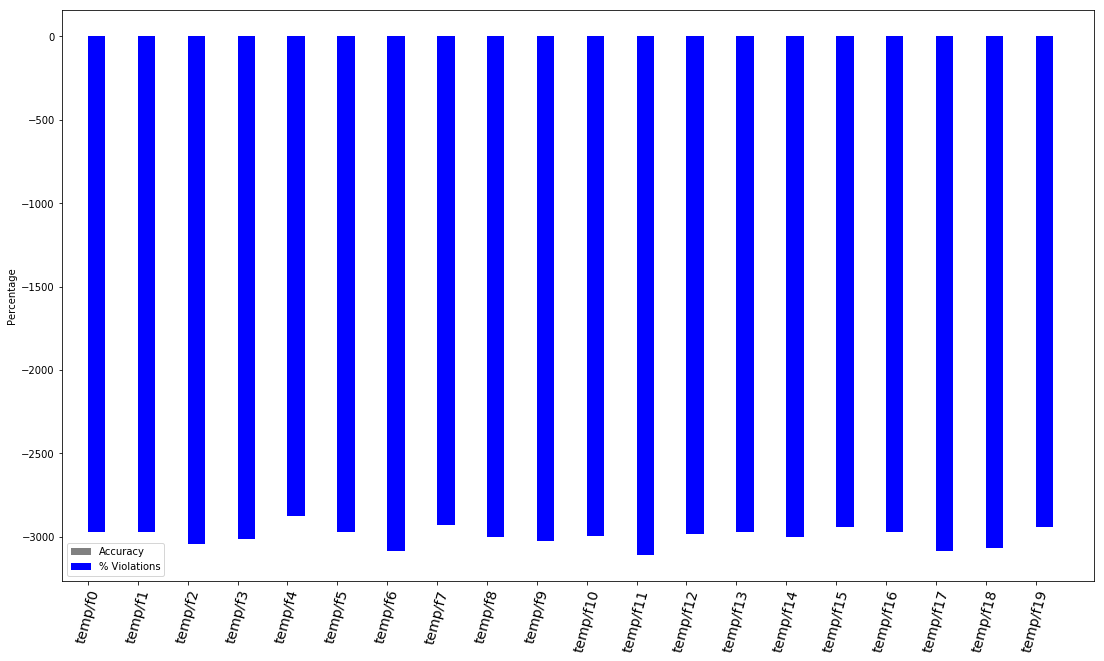

temp/f0
Area under surface (rectangular approx) =  64.13192838624221
Violations =  0.0
Average_violations =  -2974.1708201853107
MSE =  0.5140439325301988
temp/f1
Area under surface (rectangular approx) =  59.733855078866725
Violations =  0.0
Average_violations =  -2970.659542821095
MSE =  0.5110884729745236
temp/f2
Area under surface (rectangular approx) =  53.417624242027145
Violations =  0.0
Average_violations =  -3046.019672464735
MSE =  0.5092416348337736
temp/f3
Area under surface (rectangular approx) =  52.76249888462506
Violations =  0.0
Average_violations =  -3011.443923076058
MSE =  0.5099694984528182
temp/f4
Area under surface (rectangular approx) =  64.71908310620053
Violations =  0.0
Average_violations =  -2873.625016716603
MSE =  0.513726759268186
temp/f5
Area under surface (rectangular approx) =  59.13133251960075
Violations =  0.0
Average_violations =  -2968.560916959916
MSE =  0.5098581686295676
temp/f6
Area under surface (rectangular approx) =  61.10420433292059
Viola

In [4]:
#the number of times to sample
times = 10
## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0



for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    #bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        
    
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        
        bic_pred = get_bic(test_df,prior)
        
        #bic_pred = get_bic(df_test.join(pd.DataFrame(model.predict(x_test), columns = ['target'])), prior)
        
        print(tetrad.getEdges())
        print(bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    AUS.append(rectangular_approx)


0.7195360899887455


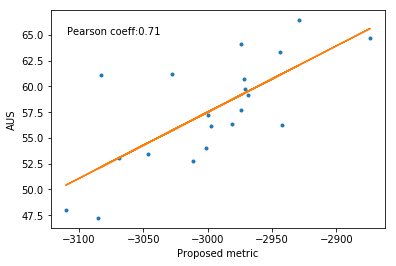

0.8106579784185599


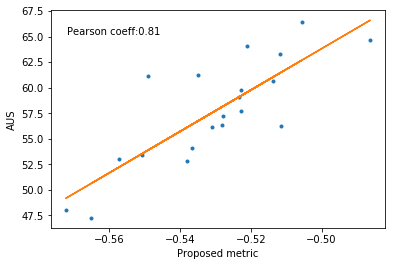

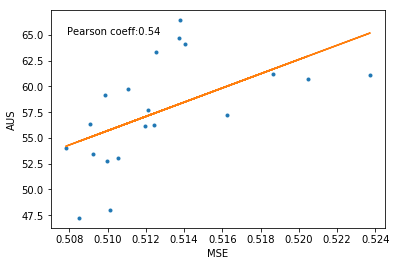

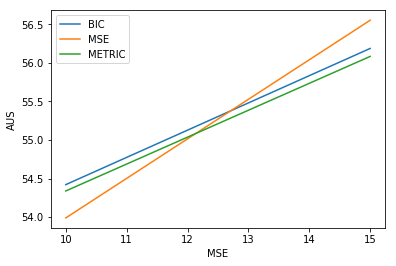

0.8106579784185599

In [5]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text


print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = -(VIO/np.max(VIO)) + np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low)) 
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]